# Industry 4.0 의 중심, AI - ML&DL

<div align='right'><font size=2 color='gray'>Machine Learning & Deep Learning with TensorFlow @ <font color='blue'><a href='https://www.facebook.com/jskim.kr'>FB / jskim.kr</a></font>, 김진수</font></div>
<hr>

# Lab: Batchnormalization Layer

## What is a batchnormalization layer?
It is a layer that normalize the output before the activation layer. [The original paper](https://arxiv.org/abs/1502.03167) was proposed by Sergey Ioffe in 2015.

Batch Normalization Layer looks like this: ![bn](https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG)

## Why batchnormalization?
The distribution of each layer's input changes because the weights of the previous layer change as we update weights by the gradient descent. This is called a covariance shift, which makes the network training difficult.

For example, if the activation layer is a relu layer and the input of the activation layer is shifted to less than zeros, no weights will be activated!

One thing also worth mentioning is that $\gamma$ and $\beta$ parameters in $$ y = \gamma \hat{x} + \beta $$ are also trainable. 

**What it means is that if we don't need the batchnormalization, its parameters will be updated such that it offsets the normalization step.**

For example, assume that

\begin{align}
\gamma &= \sqrt{\sigma^2_B + \epsilon}\\
\beta &= \mu_B
\end{align}

then

$$ y_i = \gamma \hat{x_i} + \beta = x_i $$

Also note that $\mu$ and $\sigma$ are computed using moving averages during the training step. However, during the test time, the computed $\mu$ and $\sigma$ will be used as fixed

## Conclusion
- Always use the batch normalization!

## Enough Talk: how to implement in Tensorflow

### 1. Load Library
- We use the famous MNIST data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

C:\Python\Anaconda3-50\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
mnist.train.images.shape

(55000, 784)

### 2. Define Model & Solver Class
- Object-Oriented-Programming allows to define multiple model easily
- Why do we separate model and solver classes?
  - We can just swap out the model class in the Solver class when we need a different network architecture
  - Usually we need one solver class

In [3]:
class Model:
    """Network Model Class
    
    Note that this class has only the constructor.
    The actual model is defined inside the constructor.
    
    Attributes
    ----------
    X : tf.float32
        This is a tensorflow placeholder for MNIST images
        Expected shape is [None, 784]
        
    y : tf.float32
        This is a tensorflow placeholder for MNIST labels (one hot encoded)
        Expected shape is [None, 10]
        
    mode : tf.bool
        This is used for the batch normalization
        It's `True` at training time and `False` at test time
        
    loss : tf.float32
        The loss function is a softmax cross entropy
        
    train_op
        This is simply the training op that minimizes the loss
        
    accuracy : tf.float32
        The accuracy operation
        
    
    Examples
    ----------
    >>> model = Model("Batch Norm", 32, 10)

    """
    def __init__(self, name, input_dim, output_dim, hidden_dims=[32, 32], use_batchnorm=True, activation_fn=tf.nn.relu, optimizer=tf.train.AdamOptimizer, lr=0.01):
        """ Constructor
        
        Parameters
        --------
        name : str
            The name of this network
            The entire network will be created under `tf.variable_scope(name)`
            
        input_dim : int
            The input dimension
            In this example, 784
        
        output_dim : int
            The number of output labels
            There are 10 labels
            
        hidden_dims : list (default: [32, 32])
            len(hidden_dims) = number of layers
            each element is the number of hidden units
            
        use_batchnorm : bool (default: True)
            If true, it will create the batchnormalization layer
            
        activation_fn : TF functions (default: tf.nn.relu)
            Activation Function
            
        optimizer : TF optimizer (default: tf.train.AdamOptimizer)
            Optimizer Function
            
        lr : float (default: 0.01)
            Learning rate
        
        """
        with tf.variable_scope(name):
            # Placeholders are defined
            self.X = tf.placeholder(tf.float32, [None, input_dim], name='X')
            self.y = tf.placeholder(tf.float32, [None, output_dim], name='y')
            self.mode = tf.placeholder(tf.bool, name='train_mode')            
            
            # Loop over hidden layers
            net = self.X
            for i, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('layer{}'.format(i)):
                    net = tf.layers.dense(net, h_dim)
                    
                    if use_batchnorm:
                        net = tf.layers.batch_normalization(net, training=self.mode)
                        
                    net = activation_fn(net)
            
            # Attach fully connected layers
            net = tf.contrib.layers.flatten(net)
            net = tf.layers.dense(net, output_dim)
            
            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=self.y)
            self.loss = tf.reduce_mean(self.loss, name='loss')    
            
            # When using the batchnormalization layers,
            # it is necessary to manually add the update operations
            # because the moving averages are not included in the graph            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=name)
            with tf.control_dependencies(update_ops):                     
                self.train_op = optimizer(lr).minimize(self.loss)
            
            # Accuracy etc 
            softmax = tf.nn.softmax(net, name='softmax')
            self.accuracy = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.accuracy, tf.float32))
            

In [4]:
class Solver:
    """Solver class
    
    This class will contain the model class and session
    
    Attributes
    ----------
    model : Model class
    sess : TF session
        
    Methods
    ----------
    train(X, y)
        Run the train_op and Returns the loss
        
    evalulate(X, y, batch_size=None)
        Returns "Loss" and "Accuracy"
        If batch_size is given, it's computed using batch_size
        because most GPU memories cannot handle the entire training data at once
            
    Example
    ----------
    >>> sess = tf.InteractiveSession()
    >>> model = Model("BatchNorm", 32, 10)
    >>> solver = Solver(sess, model)
    
    # Train
    >>> solver.train(X, y)
    
    # Evaluate
    >>> solver.evaluate(X, y)
    """
    def __init__(self, sess, model):
        self.model = model
        self.sess = sess
        
    def train(self, X, y):
        feed = {
            self.model.X: X,
            self.model.y: y,
            self.model.mode: True
        }
        train_op = self.model.train_op
        loss = self.model.loss
        
        return self.sess.run([train_op, loss], feed_dict=feed)
    
    def evaluate(self, X, y, batch_size=None):
        if batch_size:
            N = X.shape[0]
            
            total_loss = 0
            total_acc = 0
            
            for i in range(0, N, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                feed = {
                    self.model.X: X_batch,
                    self.model.y: y_batch,
                    self.model.mode: False
                }
                
                loss = self.model.loss
                accuracy = self.model.accuracy
                
                step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed)
                
                total_loss += step_loss * X_batch.shape[0]
                total_acc += step_acc * X_batch.shape[0]
            
            total_loss /= N
            total_acc /= N
            
            return total_loss, total_acc
            
            
        else:
            feed = {
                self.model.X: X,
                self.model.y: y,
                self.model.mode: False
            }
            
            loss = self.model.loss            
            accuracy = self.model.accuracy

            return self.sess.run([loss, accuracy], feed_dict=feed)

### 3. Instantiate Model/Solver classes

In [5]:
input_dim = 784
output_dim = 10
N = 55000

tf.reset_default_graph()
sess = tf.InteractiveSession()

# We create two models: one with the batch norm and other without
bn = Model('batchnorm', input_dim, output_dim, use_batchnorm=True)
nn = Model('no_norm', input_dim, output_dim, use_batchnorm=False)

# We create two solvers: to train both models at the same time for comparison
# Usually we only need one solver class
bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [6]:
epoch_n = 10
batch_size = 32

# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

### 4. Run the train step

In [7]:
import time
import os

def chk_processting_time(start_time, end_time):
    process_time = end_time - start_time
    p_time = int(process_time)
    p_min = p_time // 60
    p_sec = p_time %  60
    print('처리시간 : {p_min}분 {p_sec}초 경과되었습니다.'.format(
            p_min = p_min, 
            p_sec = p_sec
        ))
    return process_time


In [8]:
init = tf.global_variables_initializer()
sess.run(init)

# train my model
time1 = time.time()
for epoch in range(epoch_n):
    for _ in range(N//batch_size):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        
        _, bn_loss = bn_solver.train(X_batch, y_batch)
        _, nn_loss = nn_solver.train(X_batch, y_batch)       
    
    b_loss, b_acc = bn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    n_loss, n_acc = nn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    
    # Save train losses/acc
    train_losses.append([b_loss, n_loss])
    train_accs.append([b_acc, n_acc])
    print(f'[Epoch {epoch}-TRAIN] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    
    b_loss, b_acc = bn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    n_loss, n_acc = nn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    
    # Save valid losses/acc
    valid_losses.append([b_loss, n_loss])
    valid_accs.append([b_acc, n_acc])
    print(f'[Epoch {epoch}-VALID] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    print()
    
print('Learning Finished!')
time2 = time.time()

chk_processting_time(time1, time2)

[Epoch 0-TRAIN] Batchnorm Loss(Acc): 0.16147(94.84%) vs No Batchnorm Loss(Acc): 0.28812(90.89%)
[Epoch 0-VALID] Batchnorm Loss(Acc): 0.16086(95.14%) vs No Batchnorm Loss(Acc): 0.27907(91.22%)

[Epoch 1-TRAIN] Batchnorm Loss(Acc): 0.11066(96.53%) vs No Batchnorm Loss(Acc): 0.14739(95.77%)
[Epoch 1-VALID] Batchnorm Loss(Acc): 0.12812(96.22%) vs No Batchnorm Loss(Acc): 0.16308(95.38%)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): 0.08706(97.37%) vs No Batchnorm Loss(Acc): 0.15819(95.37%)
[Epoch 2-VALID] Batchnorm Loss(Acc): 0.10785(96.58%) vs No Batchnorm Loss(Acc): 0.16741(95.14%)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): 0.08644(97.16%) vs No Batchnorm Loss(Acc): 0.13417(96.19%)
[Epoch 3-VALID] Batchnorm Loss(Acc): 0.11539(96.48%) vs No Batchnorm Loss(Acc): 0.17258(95.50%)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): 0.07433(97.70%) vs No Batchnorm Loss(Acc): 0.13527(95.99%)
[Epoch 4-VALID] Batchnorm Loss(Acc): 0.11327(97.10%) vs No Batchnorm Loss(Acc): 0.16808(95.32%)

[Epoch 5-TRAIN] Batchnorm Loss(Acc)

58.13749694824219

### 5. Performance Comparison
* With the batchnormalization, the loss is lower and it's more accurate too!

In [9]:
bn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.086377114, 0.9746]

In [10]:
nn_solver.evaluate(mnist.test.images, mnist.test.labels)  

[0.1820858, 0.9609]

In [11]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

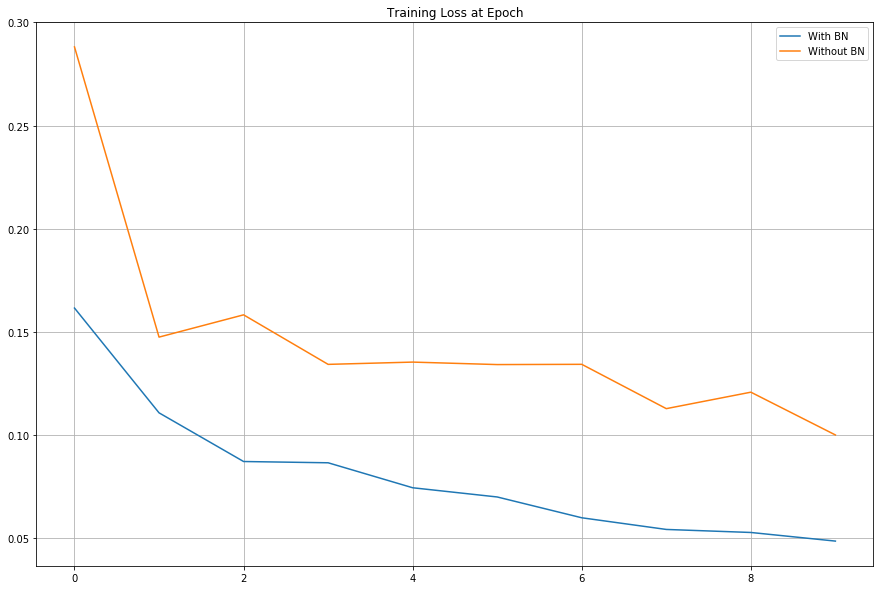

In [12]:
plot_compare(train_losses, title='Training Loss at Epoch')

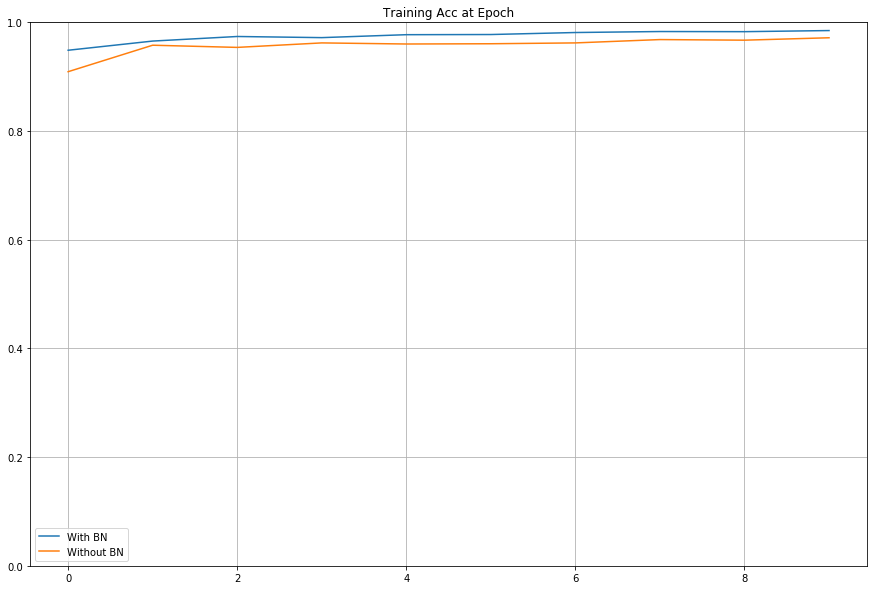

In [13]:
plot_compare(train_accs, [0, 1.0], title="Training Acc at Epoch")

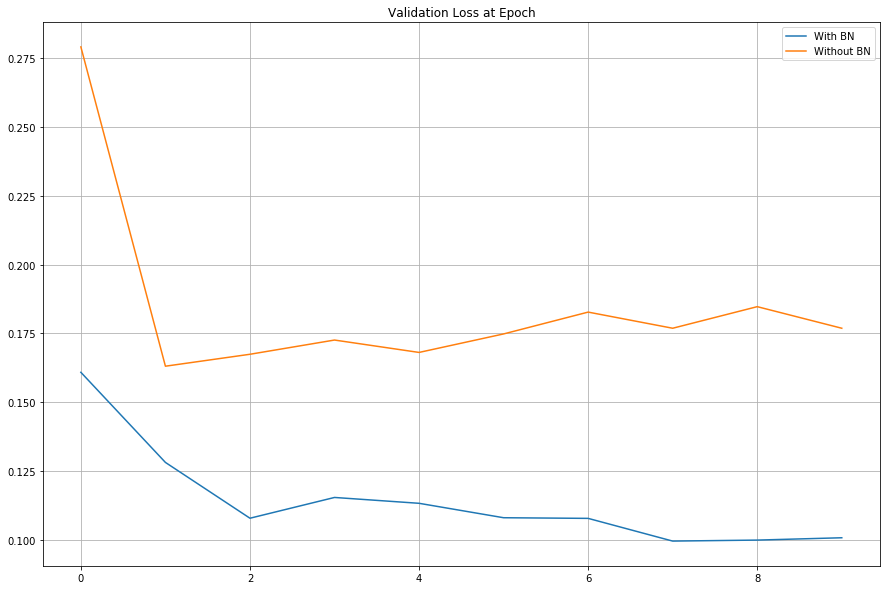

In [14]:
plot_compare(valid_losses, title='Validation Loss at Epoch')

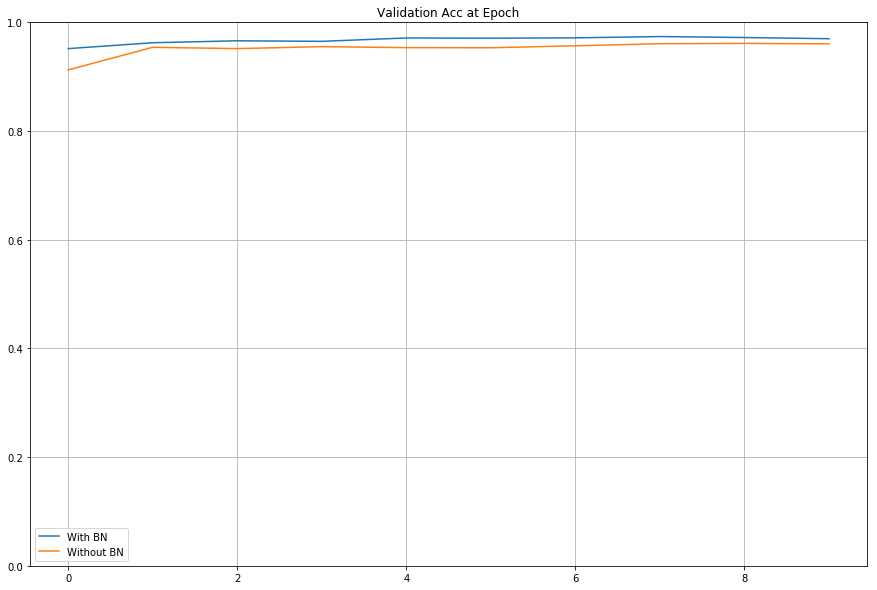

In [15]:
plot_compare(valid_accs, [0, 1.], title='Validation Acc at Epoch')

<hr>
<marquee><font size=3 color='brown'>The BigpyCraft find the information to design valuable society with Technology & Craft.</font></marquee>
<div align='right'><font size=2 color='gray'> &lt; The End &gt; </font></div>